# Human Activities - Classification


Pour ce TP nous allons étudier et mettre en pratique plusieurs méthodes de classification supervisée sur les 
données de smartphones déjà étudiées dans les TPS précédents.

In [1]:
%matplotlib inline
from pylab import *
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing 

## Importation des données
Nous reprenons les codes d'importation des TPs précédents.

In [2]:
votre_path= "/Users/bmichel/Dropbox/Enseignements/ADD-M2Stat/Tps-Notebooks/Datasets/UCI HAR Dataset/"
data_path = votre_path + "features.txt"
features_names =    pd.read_csv(data_path,delim_whitespace=True,header=None)
data_path = votre_path + "train/X_train.txt"
activity_features = pd.read_csv(data_path,delim_whitespace=True,
                                header=None,names=features_names.values[:,1])
data_path = votre_path + "train/y_train.txt"
activity  =    pd.read_csv(data_path,delim_whitespace=True,header=None)
activity  =  activity.values[:,0] -  1
activity_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
data_path = votre_path + "train/subject_train.txt"
sujet =  pd.read_csv(data_path,delim_whitespace=True,header=None)
sujet =sujet.values[:,0]

## ACP des données activity_features

Tracé du nuage des deux premières composantes en distinguant les activités, beaucoup de recouvrement entre les classes sur ces deux premières composantes.

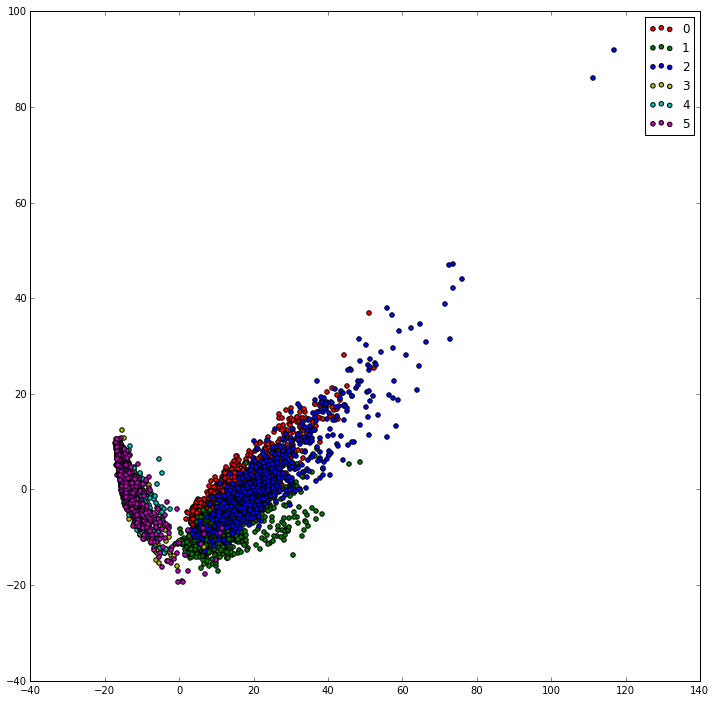

In [3]:
from sklearn.decomposition import PCA
features_nor  = preprocessing.scale(activity_features)
pca = PCA(n_components=5)  
pca.fit(features_nor) 
DataExtract = pca.transform(features_nor)
ACP0 = DataExtract[:,0]
ACP1 = DataExtract[:,1]

plt.figure(figsize=(12, 12))
for c, i, act in zip("rgbycm", range(0,6),range(0,6)):
    plt.scatter(ACP0[activity==i],ACP1[activity==i], c=c, label=act)
plt.legend()

## Problème de classification à deux classes

Dans toute la première partie du TP, on considère un problème de classification à deux classes. Pour cela, on commence par extraire les donnnés pour les activités  3 et 4 uniquement :

In [4]:
n,p = shape(activity_features)
index_act34 = [i for i in range(n) if (activity[i]  ==3)   or (activity[i]  == 4)  ] 
sujet_act34 = sujet[index_act34]
activity34 = activity[index_act34]
features34 = activity_features.iloc[index_act34]
print(shape(features34))

(2660, 561)


### Présélection de features  pour réduire la dimension (screening)

Pour diminuer les temps de calul on pré-sélectionne les 20 features les plus discriminants pour un critère unvarié :
http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Attention, cette méthode ne garantit en rien que l'on a choisi le "meilleur" groupe de 20 variables pour le problème de classification.

In [5]:
from sklearn.feature_selection import SelectKBest, f_classif
# objet sklearn pour faire cette reduction de dim
Selec = SelectKBest(f_classif, k=20)
features34 = Selec.fit_transform(features34, activity34)
shape(features34)


(2660, 20)

Pour chacune des méthodes de classificiation listées ci-dessous, nous construisons un predicteur de l'activité en utilisant comme données d'apprentissage la base (features34,activity34).
- Classifieur naif bayesien avec la fonction GaussianNB()
- Classifieur des k plus proches voisins avec neighbors.KNeighborsClassifier()
- Classifieur SVM avec svm.SVC()
- Forêt aléatoire avec RandomForestClassifier()

Une présentation de chacune des ces fonction est accessible depuis la page : http://scikit-learn.org/stable/user_guide.html

#### Classifieur naif bayesien

In [6]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB()
gnb.fit(features34, activity34)
feat_pred_gnb = gnb.predict(features34)
# taux d'erreur :
print("Taux d'erreur (brutalement) calculé sur les données d'apprentissage :") 
print((activity34 != feat_pred_gnb).sum() / float(len(activity34)))
# ou sinon :
print("Taux de bien classés (brutalement) calculé sur les données d'apprentissage :") 
print(gnb.score(features34, activity34))

Taux d'erreur (brutalement) calculé sur les données d'apprentissage :
0.130827067669
Taux de bien classés (brutalement) calculé sur les données d'apprentissage :
0.869172932331


Ouf, ces deux quantités se somment bien à un. Evidemment ce n'est pas pas la bonne façon d'estimer le risque de l'estimateur, cet estimation de l'erreur de généralisation est beaucoup trop optimiste.

#### Classifieur des k plus proches voisins

In [7]:
from sklearn import neighbors
nn = neighbors.KNeighborsClassifier(n_neighbors = 4, weights="uniform")
nn.fit(features34, activity34)
feat_pred_nn = nn.predict(features34)
print("Taux de bien classés (brutalement) calculé sur les données d'apprentissage :") 
print(nn.score(features34, activity34))

Taux de bien classés (brutalement) calculé sur les données d'apprentissage :
0.95


#### Classifieur SVM

In [8]:
from sklearn import svm
rbf_svm = svm.SVC(kernel='rbf')
rbf_svm.fit(features34, activity34)
feat_pred_svm = rbf_svm.predict(features34)
print("Taux de bien classés (brutalement) calculé sur les données d'apprentissage :") 
print(rbf_svm.score(features34, activity34))

Taux de bien classés (brutalement) calculé sur les données d'apprentissage :
0.900751879699


#### Classifieur par forêt aléatoire

In [9]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=50)
RF.fit(features34, activity34)
feat_pred_RF = RF.predict(features34)
print("Taux de bien classés (brutalement) calculé sur les données d'apprentissage :") 
print(RF.score(features34, activity34))

Taux de bien classés (brutalement) calculé sur les données d'apprentissage :
1.0


## Evaluation de l'erreur par validation / test

Estimer les performances de classification sur l'échantillon d'apprentissage conduit à sur estimer systématiquement l'erreur de généralisation du prédicteur construit.

Quand on dispose d'assez de données, on peut contourner ce problème de surapprentissage systématique en utilisant un ensemble de validation. Pour cela on suppose que l'on dispose de deux ensembles de données :
- l'ensemble d'apprentissage : utilisé pour construire des prédicteurs ;
- l'ensemble de test : utilisé pour évaluer les performances des prédicteurs.

In [10]:
from sklearn import cross_validation
features_train, features_test, activity_train, activity_test \
        = cross_validation.train_test_split(features34,activity34, test_size=0.4)
# on vérifie la proportion de données utilisées pour l'apprentissage et pour le test :
print(len(activity_train)/ float(len(activity34)))
print(len(activity_test)/ float(len(activity34)))
print(shape(features_test))


0.6
0.4
(1064, 20)


On évalue maintenant le risque d'un classifieur par plus proches voisins sur ce découpage des données :

In [ ]:
nn_train_test = neighbors.KNeighborsClassifier(n_neighbors = 4, weights="uniform")
nn_train_test.fit(features_train, activity_train)
print("Taux de bien classés estimés sur l'echantillon test :") 
nn_train_test.score(features_test,activity_test)

contre 0.95 précédemment. 

**Exercice ** Reproduire l'expérience plusieurs fois pour vous en convaincre et dresser un boxplot des scores obtenus.

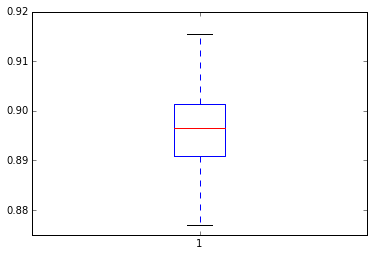

In [11]:
score_train_test = []
for simu in range(100) :
    features_train, features_test, activity_train, activity_test \
        = cross_validation.train_test_split( \
            features34,activity34,test_size=0.4)
    nn_train_test = neighbors.KNeighborsClassifier(n_neighbors = 4,\
                                                   weights="uniform")
    nn_train_test.fit(features_train, activity_train)
    score_train_test.append(nn_train_test.score(features_test,activity_test))
B = plt.boxplot(score_train_test)

**Excercice : **tracer la courbe d'erreur du classifieur par plus proches voisins en fonction du nombre de voisins utilisés, en utilisant cette méthode de découpage train / test.

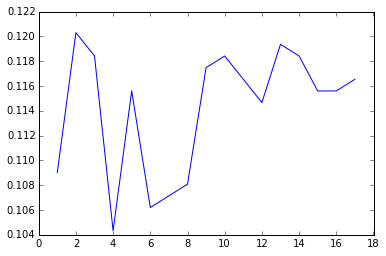

In [12]:
Score_grillek = []
k_vec = range(1,18)
for k in k_vec :
    nn_train_test = neighbors.KNeighborsClassifier(n_neighbors = k, weights="uniform")
    nn_train_test.fit(features_train, activity_train)
    Score_grillek.append(nn_train_test.score(features_test,activity_test))
Erreur  = 1 - np.array(Score_grillek)    
plt.plot(k_vec, Erreur )

En réalité, si l'on désire une estimation du modèle sélectionné ainsi, il faut découper l'échantillon disponible non pas en deux mais en trois parties :
- l'ensemble d'apprentissage : utilisé pour construire des modèles ;
- l'ensemble de validation : utilisé pour choisir un modèle ;
- l'ensemble de test : utilisé pour évaluer les performances du modèle
  finalement choisi.
  
Ceci est notamment important lorsque l'on souhaite comparer deux méthodes qui ont toutes les deux fait intervenir un réglage de paramètres (ici le nombre de voisins).

Dans l'exemple ci-dessous nous comparons le classifieur SVM (avec sélection du paramètre de régularisation $C$) au classifieur par plus proches voisins (avec sélection du nombre de voisins). Nous retenons la moitié des données pour l'apprentissage, un quart pour la validation et un quart pour le test.

In [ ]:
features_train, features_valid_test, activity_train, activity_valid_test = \
        cross_validation.train_test_split(features34,activity34, test_size=0.5)
features_valid, features_test, activity_valid, activity_test =\
        cross_validation.train_test_split(features_valid_test,activity_valid_test, test_size=0.5)

##### Pour K-NN :

In [ ]:
score_nn = []
k_vec = range(1,15)
for k in k_vec :
    nn = neighbors.KNeighborsClassifier(n_neighbors = k, weights="uniform")
    nn.fit(features_train, activity_train)
    score_nn.append(nn.score(features_valid,activity_valid))
k_opt = k_vec[np.argmax(score_nn)]
print("nombre  selectionné de voisins :") 
print(k_opt)
nn_opt = neighbors.KNeighborsClassifier(n_neighbors = k_opt, weights="uniform")
nn_opt.fit(features_train, activity_train)
print("Score estimé en train/valid/test :") 
print(nn_opt.score(features_test,activity_test))

##### Pour SVM :

In [ ]:
score_svm = []
C_vec = array([1,5,10,100,1000,10^6])
for C in C_vec :
    rbf_svm = svm.SVC(kernel='rbf',C = C)
    rbf_svm.fit(features_train, activity_train)
    score_svm.append(rbf_svm.score(features_valid,activity_valid))    
C_opt = C_vec[np.argmin(score_svm)]
rbf_svm_opt = svm.SVC(kernel='rbf',C = C_opt)
rbf_svm_opt.fit(features_train, activity_train) 
print("Score estimé en train/valid/test: ") 
print(rbf_svm_opt.score(features_test,activity_test)) 

**Excercice : ** Rejouez plusieurs fois le protocole (Par exemple pour knn) pour vérifier la nécessité de découper en trois l'échantillon. Vous pourrez comparer le score de classification estimé sur l'échantillon de validation et sur l'échantillon de test.

In [13]:
simu_valid = []
simu_test = []
for simu in range(100) :
    
    # grille de valeurs pour k :
    k_vec = range(1,18)        
    # Split :
    features_train, features_valid_test, activity_train, activity_valid_test = \
            cross_validation.train_test_split(features34,activity34, test_size=0.5)
    features_valid, features_test, activity_valid, activity_test = \
            cross_validation.train_test_split(features_valid_test,activity_valid_test, test_size=0.5)
    
    # boucle d estimation de l erreur sur une simu :
    score_nn = []
    for k in k_vec :
        nn = neighbors.KNeighborsClassifier(n_neighbors = k,
                                            weights="uniform")
        nn.fit(features_train, activity_train)
        score_nn.append(nn.score(features_valid,activity_valid))
        
    # Modele selctionne : 
    k_opt = k_vec[np.argmax(score_nn)]
    nn_opt = neighbors.KNeighborsClassifier(n_neighbors = k_opt, weights="uniform")        
    nn_opt.fit(features_train, activity_train)
    # score reevalue sur les donnees de validation :
    simu_valid.append(nn_opt.score(features_valid,activity_valid))
    simu_test.append(nn_opt.score(features_test,activity_test))    
print(mean( simu_valid))
print(mean(simu_test))

0.897518796992
0.890661654135


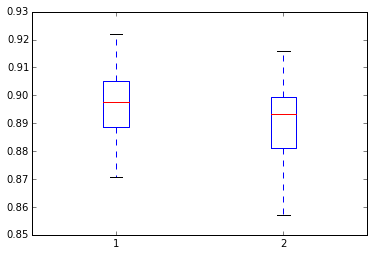

In [14]:
B = plt.boxplot([simu_valid, simu_test])

On voit effectivement que le taux de bon classement estimé sur l'échantillon de validation est légèrement trop optimiste.

# Estimation du risque par validation croisée 

Le principal défaut de l'approche par train/validation/test est qu'elle demande un grand
volume de données. En pratique, on lui préfère en général une méthode de
validation croisée, même si cette deuxième approche a le défaut d'être plus coûteuse en temps de
calcul. On présente ci-dessous la méthode du de validation croisée de type **k-fold**.

L'idée principale de la méthode est de faire jouer à chaque observation à la fois le rôle de donnée d'apprentissage et celui de donnée de validation. 

Le principe consiste à partitionner aléatoirement les données $D=(\mathbf{x}_i,y_i)_{1\leq i\leq N} $ 
en $K$ morceaux disjoints de tailles comparables :
$D^1,\ldots,D^K$. On prend généralement $K=5$ ou $10$. La méthode du **leave-one-out (Loo)** correpond au choix $K=N-1$. 

On estime alors la qualité d'une classes de predicteurs  de la
façon suivante :
- pour tout $k \in \{1,\dots, K\}$, on construit un predicteur $\hat f^k$ sur l'ensemble d'apprentissage $D^{-k} := D\setminus D^k$ ;
- on calcule le risque empirique de $\hat f^k$ par
$$
\frac{1}{N}\sum_{k=1}^K\sum_{\mathbf{x}_i\in D^k} \ell(f^k(\mathbf{x}_i),y_i),
$$
où $\ell$ est la perte utilisée.

En d'autres termes, on construit autant de prédicteurs qu'il y a de morceaux de
l'ensemble d'apprentissage. Chaque prédicteur est évalué sur les éléments du
morceau qui n'a pas vu en apprentissage (et qui joue donc le rôle d'un
ensemble de validation). 

Lorsque l'on souhaite régler un paramètre en utlisant la validation croisée, par exemple le nombre de voisins $k$ pour knn, on procède comme suit :
- on évalue les performances des prédicteurs via le risque empirique calculé sur la morceau hors apprentissage, comme expliqué ci-dessus ;
- on détermine la valeur optimale du paramètre ;
- on construit finalement un predicteur pour le paramètre sélectionné, en utilisant comme base d'apprentissage toutes les données.


**Comparaison entre LOO et methodes k folds, quelques repères :** 
- LOO est plus a un coût computationnel plus élevé que les méthodes k-fold pour k petit (pour k = 5 ou 10 par exemple)
- L'estimation de l'erreur fournie par LOO a généralement une variance plus élevée que celles obtenues par un k-fold pour k petit.
- En revanche, si l'erreur de classification décroit très rapidement avec $n$, les méthodes k-fold avec k petit peuvent surestimer significativement l'erreur de généralisation.
- En général, il est souvent recommandé d'utiliser les méthodes k-fold avec k = 5 ou 10.

###  Estimation de l'erreur par 10-fold :

In [ ]:
nn_val_croisee = neighbors.KNeighborsClassifier(n_neighbors = 10)
scores = cross_validation.cross_val_score(nn_val_croisee, features34, activity34, cv=10)
print(scores)
print(mean(scores))

###  Estimation de l'erreur par Loo

In [ ]:
from sklearn.cross_validation import LeaveOneOut
loo = LeaveOneOut(len(activity34))
nn_val_croisee = neighbors.KNeighborsClassifier(n_neighbors = 10)
scores = cross_validation.cross_val_score(nn_val_croisee, features34, activity34, cv=loo)
mean(scores) 

## Sélection du nombre de plus proches voisins par validation croisée 10 fold

In [ ]:
score_grid = []
k_vec = range(1,30)
for k in k_vec :
    nn_val_croisee = neighbors.KNeighborsClassifier(n_neighbors = k)
    score_k = cross_validation.cross_val_score(nn_val_croisee, features34, activity34, cv=10)
    score_grid.append(mean(score_k))

plt.plot(k_vec,score_grid)

** Exercice ** faire de même pour choisir la constance  C de SVM

## la fonction GridSearchCV

En pratique, on a souvent besoin de régler les paramètres par validation croisée. La fonction GridSearchCV permet d'effectuer cette tache de façon simple, en répartissant éventuellement les calculs sur plusieurs coeurs.

In [ ]:
from sklearn.grid_search import GridSearchCV
from time import time

# la grille de parametres a regler sont definis dans un dictionnaire (dict)
tuned_parameters = {'n_neighbors': range(2,100)}
start = time()
nnGrid = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters,cv=5)
nnGrid.fit(features34, activity34)
print(str(time() - start)+ " sec")

Nous utilisant maintenant 3 coeurs (il y a en 4 sur mon mac) et nous comparons les temps de calcul :

In [ ]:
start = time()
nnGrid = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters,cv=5,n_jobs=3)
nnGrid.fit(features34, activity34)
print(str(time() - start)+ " sec")

** Exercice :** Utiliser la fonction GridSearchCV pour comparer les performances de classification du classifieur SVM avec ou sans présélection de features (avec SelectKBest), en réglant dans les deux cas la constante $C$ par validation croisée.

# Classification multiclasses 

Nous allons maintenant nous intéresser au problème de la classification des 6 classes d'activité. La perte utilisée ici est la perte de mauvais classement "sèche" (harsh metric).

## Présélection de features

Pour réduire les temps de calcul (il s'agit d'un TP...) nous appliquons la même stratégie de présélection de features que pour le cas à deux classes :

In [ ]:
Selec = SelectKBest(f_classif, k=20)
features_all_activities = Selec.fit_transform(activity_features, activity)
shape(features_all_activities)

#### Classifieur naif bayesien multiclasses

In [ ]:
gnb = GaussianNB()
scores  = cross_validation.cross_val_score(gnb, features_all_activities, activity, cv=10)
print(scores)
print(mean(scores))

#### Classifieur des k plus proches voisins multiclasses

In [ ]:
nn = neighbors.KNeighborsClassifier(n_neighbors = 4, weights="uniform")
scores  = cross_validation.cross_val_score(nn, features_all_activities, activity, cv=10)
print(scores)
print(mean(scores))

#### Classifieur SVM multiclasses

Il s'agit de l'approche “one-against-one” pour la classification multi- class classification. Si K classes sont présentes,  K * (K - 1) / 2 problèmes de classifications à deux classes sont construits. La fonction de décision finale "aggrège" les décisions de ces K * (K - 1) / 2 classifications.

In [ ]:
rbf_svm = svm.SVC(kernel='rbf')
scores  = cross_validation.cross_val_score(rbf_svm, features_all_activities, activity, cv=10)
print(scores)
print(mean(scores))

#### Foret aleatoire multiclasses

In [ ]:
RF = RandomForestClassifier(n_estimators=50)
scores  = cross_validation.cross_val_score(RF, features_all_activities, activity, cv=10)
print(scores)
print(mean(scores))

In [ ]:
print(mean(scores))

** Exercice :** Utiliser la fonction GridSearchCV pour choisir le nombre de voisin pour l'estimateur knn dans ce cas multiclasses. Ajuster le modèle finalement choisi sur la base d'apprentissage et dresser la matrice de confusion